## Q1
Write python code from scratch for JPEG compression for image (lena.jpg) and demonstrate results of each step and also compare final result with OpenCV functions in terms of in terms of RMSE and PSNR (dB).

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

from numpy import r_
from numpy import pi

In [21]:
from math import log10, sqrt
def PSNR_RMSE(img1, img2):
    
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    rmse= sqrt(mse)  ## Root mean square 
    psnr = 20 *log10(max_pixel /rmse) # in dB
    return psnr,rmse

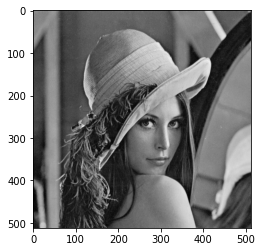

In [13]:
im = cv2.imread("lena.jpg",0)
plt.imshow(im,cmap='gray')
plt.show()

In [14]:
# Define 2D DCT and IDCT
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

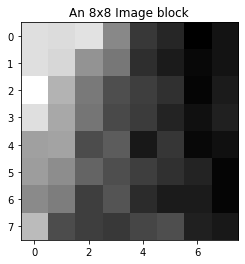

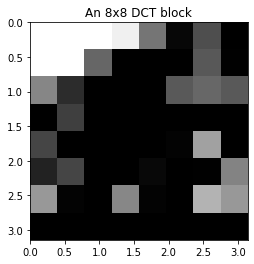

In [16]:
# Perform a blockwise DCT
imsize = im.shape
dct = np.zeros(imsize)

# Do 8x8 DCT on image (in-place)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)] )

#Extract 8x8 block and look at its DCT coefficients
pos = 128
# Extract a block from image
plt.figure()
plt.imshow(im[pos:pos+8,pos:pos+8],cmap='gray')
plt.title( "An 8x8 Image block")
plt.show()

# Display the dct of that block
plt.figure()
plt.imshow(dct[pos:pos+8,pos:pos+8],cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,pi,pi,0])
plt.title("An 8x8 DCT block")
plt.show()

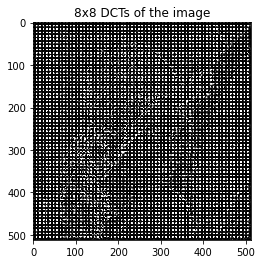

In [17]:
# Display entire DCT
plt.figure()
plt.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title("8x8 DCTs of the image")
plt.show()

Keeping only 6.530762% of the DCT coefficients


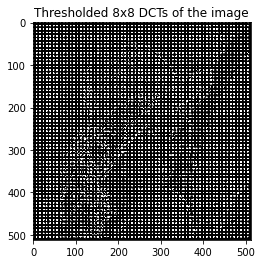

In [18]:
# Threshold DCT coefficients

# Threshold
thresh = 0.012
dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))

plt.figure()
plt.imshow(dct_thresh,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "Thresholded 8x8 DCTs of the image")

percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))



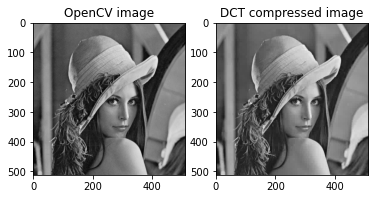

In [24]:
# Compare DCT compressed image with original
im_dct = np.zeros(imsize)

for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        im_dct[i:(i+8),j:(j+8)] = idct2( dct_thresh[i:(i+8),j:(j+8)] )

#Converting floating data to usigned interger data        
im_dct = im_dct.astype('uint8')   

#Compare DCT compressed image with original
plt.subplot(1,2,1)
plt.imshow(im,cmap='gray')
plt.title("OpenCV image" )
plt.subplot(1,2,2)
plt.imshow(im_dct, cmap='gray')
plt.title("DCT compressed image" )
plt.show()



In [23]:
# Comparison
psnr_dct,rmse_dct= PSNR_RMSE(im, im_dct)
print("PSNR: ", psnr_dct)
print("RMSE: ", rmse_dct)

PSNR:  34.52705924037227
RMSE:  4.788364676932708


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from tabulate import tabulate

## Q2
### Improved Adaptive Huffman Compression Algorithm

Write python code from scratch for Adaptive Huffman coding explained by author in research paper 1 and demonstrate results of each step. 

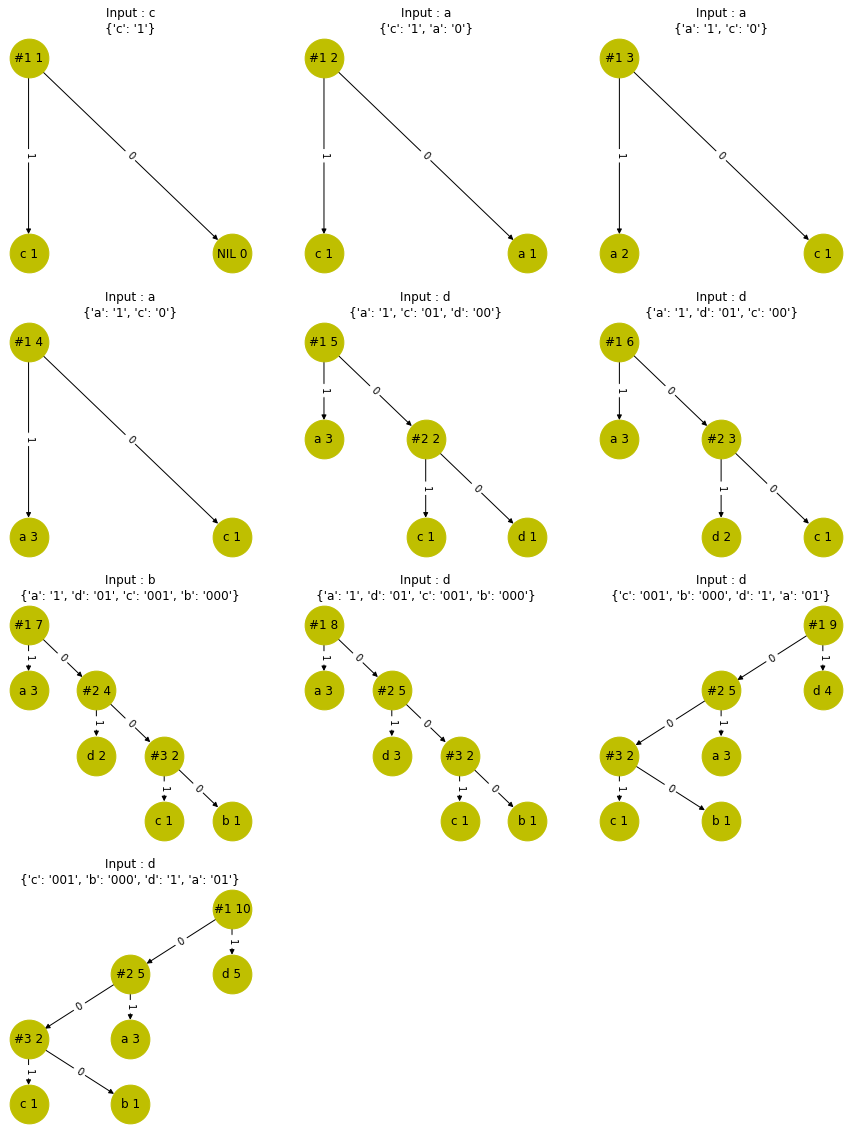

From Final Tree:

Symbol      Code
--------  ------
c            001
b            000
d              1
a             01

Encoded Data
---  --  --  --  -  -  ---  -  -  -
c    a   a   a   d  d  b    d  d  d
001  01  01  01  1  1  000  1  1  1
---  --  --  --  -  -  ---  -  -  -
Length of encoded data :  17


In [47]:
def swap_nodes(G,a,b,leaf):
    if a==leaf:
        leaf=b
    elif b==leaf:
        leaf=a
        
    if list(G.predecessors(b))[0] != list(G.predecessors(a))[0]:
        G.nodes[list(G.predecessors(b))[0]]['freq'] -= 1
    temp = G.nodes[b]['freq']
    G.nodes[b]['freq'] = G.nodes[a]['freq']
    G.nodes[a]['freq'] = temp
    
    nx.relabel_nodes(G,{b:'temp'},copy=False)
    nx.relabel_nodes(G,{a:b},copy=False)
    nx.relabel_nodes(G,{'temp':a},copy=False)
    
    return leaf
    
def plot_graph(G,ax):            
    pos = graphviz_layout(G, prog="dot")
    labels = {index:index+' '+str(val) for index,val in nx.get_node_attributes(G, 'freq').items()}
    #nx.draw(G, pos,with_labels=True,labels=labels,node_size=2500)
    nx.draw(G, pos,with_labels=True,labels=labels,ax=ax,node_size=1500,node_color='y')
    edge_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,ax=ax)
    #ax.set_axis_off()
    #plt.show()
    
def get_symbol(G,root):
    symbol = {}
    nodes = [n for n,x in G.out_degree() if x==0 ]
    if 'NIL' in nodes : nodes.remove('NIL')
    for ele_2 in nodes:
        path = nx.shortest_path(G, source=root, target=ele_2)
        symbol[ele_2] = ''.join([str(G[u][v]['weight']) for u,v in zip(path[0:],path[1:])])
    return symbol



code = 'caaaddbddd'

code = list(code)

G = nx.DiGraph()
G.add_nodes_from([(code[0],{'freq':1})])
G.add_nodes_from([('NIL',{'freq':0})])
root = '#1'
leaf = "NIL"
count_i = 1
G.add_nodes_from([(root,{'freq':1})])
G.add_edge(root,code[0],weight=1)
G.add_edge(root,"NIL",weight=0)

fig = plt.figure(figsize=(15,int(np.ceil(len(code)/3))*5))
# compute a grid size that will fit all graphs on it (couple blanks likely)
#nr = int(np.ceil(np.sqrt(len(code))))
fig, ax = plt.subplots(int(np.ceil(len(code)/3)), 3, num=1)
[axi.set_axis_off() for axi in ax.ravel()]
plot_graph(G,ax[0,0])
ax[0,0].title.set_text('Input : '+code[0]+'\n'+str(get_symbol(G,root)))
ax_i = 1


for ele in code[1:]:
    if  ele in G.nodes:
        dif1 = np.where(np.array(list(nx.get_node_attributes(G,'freq').values())) < G.nodes[ele]['freq'])[0]
        for node in nx.shortest_path(G, source=root, target=ele):
            G.nodes[node]['freq'] += 1            
        dif2 = np.where(np.array(list(nx.get_node_attributes(G,'freq').values())) < G.nodes[ele]['freq'])[0]
        index = np.array(list(filter(lambda x: x not in dif1, dif2)))
        if len(index) > 0 and len(list(G.nodes)[index[0]])<2:
            leaf = swap_nodes(G,list(G.nodes)[index[0]],ele,leaf)
            
            
        
    else:
        if 'NIL' in G.nodes:
            leaf = ele
            nx.relabel_nodes(G,{'NIL':ele},copy=False)
            G.nodes[ele]['freq'] = 1
            G.nodes[root]['freq'] = G.nodes[code[0]]['freq'] + G.nodes[ele]['freq']
            #break
            
        else:    
            
            in_node = list(G.predecessors(leaf))[0]  
            
            G.remove_edge(in_node,leaf)
            G.add_nodes_from([(ele,{'freq':1})])
            count_i +=1
            new_node = '#'+str(count_i)
            G.add_nodes_from([(new_node,{'freq':G.nodes[leaf]['freq']})])
            G.add_edge(in_node,new_node,weight=0)
            G.add_edge(new_node,leaf,weight=1)
            G.add_edge(new_node,ele,weight=0)

            for node in nx.shortest_path(G, source=root, target=new_node):
                G.nodes[node]['freq'] += 1
            leaf = ele
    axis_index = np.unravel_index(ax_i, ax.shape)
    plot_graph(G,ax[axis_index[0],axis_index[1]])
    ax[axis_index[0],axis_index[1]].title.set_text('Input : '+ele+'\n'+str(get_symbol(G,root)))
    ax_i += 1
    
plt.show()
symbol = get_symbol(G,root)
print("From Final Tree:\n")
print(tabulate(symbol.items(),headers=['Symbol', 'Code']))
print("\nEncoded Data")
encode = list([symbol[inp] for inp in list(code)])
print(tabulate([code,encode]))
print("Length of encoded data : ",sum(map(len,encode)))




## Q3

Write python code from scratch for Modified BTC for natural image compression   explained by author in research paper 2 (barba.png) and demonstrate results of each step. Also compare the results with original BTC algorithm in terms of RMSE and PSNR (dB). 

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log10, sqrt

In [23]:
def PSNR_RMSE(img1, img2):   
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    rmse= sqrt(mse)  ## Root mean square 
    psnr = 20 *log10(max_pixel /rmse)
    return rmse,psnr

In [24]:
def btc_block(img_block,mod=0):
    """
    This function will calculate the coefficient and bitmap of the BTC Algorithm.
    """
    m = img_block.shape[0] * img_block.shape[1]
    h = float(np.sum(img_block) / m)
    sigma = np.std(img_block)
    #Both the mean 'h' and the standard deviation 'sigma' are assumed to be 8 bit.    
    
    if(mod):
        h_6bit=int(round(h,0))>>2 #Truncated to 6 bits
        sigma_4bit=int(round(sigma,0))>>4 #Truncated to 4 bits
        h_q=h_6bit<<2                #Expanded to 8 bits but uses only 6 bits
        sigma_q=sigma_4bit<<4        #Expanded to 8 bits but uses only 4 bits
        q = img_block[np.where(img_block > h_q)].shape[0]  #Number of pixels with value greater than quantized mean
        if(q==0 or q==m):
            q=int(m/2)             #Done to avoid division by zero
        a = h_q - sigma_q * math.sqrt(float(q) / (m - q)) #Compute the lower and higher pixel values,
        b = h_q + sigma_q * math.sqrt((m - q) / float(q)) #while retaining the same mean and standard deviation.
        
    else:
        q = img_block[np.where(img_block > h)].shape[0]  #Number of pixels with value greater than quantized mean
        if(q==0 or q==m):
            q=int(m/2)             #Done to avoid division by zero
        a = h - sigma * math.sqrt(float(q) / (m - q)) #Compute the lower and higher pixel values,
        b = h + sigma * math.sqrt((m - q) / float(q)) #while retaining the same mean and standard deviation.
        
    #Encoder to encode the bitmap
    bitmap = np.zeros((img_block.shape[0], img_block.shape[1]))
    for i in range(0, img_block.shape[0]):
        for j in range(0, img_block.shape[1]):
            if(mod):
                if (img_block[i, j] >= h_q):        #Bitmap is 1 if the pixel value is greater than the quantized mean,
                    bitmap[i, j] = 1                #Else zero.
            else:
                if (img_block[i, j] >= h):        #Bitmap is 1 if the pixel value is greater than the quantized mean,
                    bitmap[i, j] = 1
    
    # Decoder to decode the bitmap to produce compressed image
    result = img_block.copy()
    for i in range(0, img_block.shape[0]):
        for j in range(0, img_block.shape[1]):
            if (bitmap[i, j]):
                result[i, j] = round(b, 0)   #Pixel value is set to the higher of the two thresholds if bitmap is 1,
            else:
                result[i, j] = round(a, 0)   #and to the lower of the two thresholds if bitmap is zero.
    
    return bitmap, result


def btc_manual(img, block, mod=0):
    """
    This function will doing Block Truncation Coding of one entire image.
    """
    result = img.copy()
    bitmap = img.copy()
    #Split the image into non-overlapping blocks of given size and apply the BTC algorithm on each.
    for i in range(0, img.shape[0], block):
        for j in range(0, img.shape[1], block):
            bitmap[i: i + block, j: j + block], result[i: i + block, j: j + block] = btc_block(
                img[i: i + block, j: j + block], mod)
    return bitmap, result

In [25]:
image = cv2.imread("/kaggle/input/barba-image/barba.png",0)

# Perform Block Truncation Coding (BTC)
bitmap, result = btc_manual(image, 4, mod = 0) #Standard block size of 4x4
bitmap_mod, result_mod = btc_manual(image, 4, mod=1)
# Measure PSNR
rmse,psnr= PSNR_RMSE(image, result)
print("Standard BTC RMSE = ", rmse)
print("Standard BTC PSNR = ", psnr)

rmse_mod,psnr_mod= PSNR_RMSE(image, result_mod)
print("Modified BTC RMSE = ", rmse_mod)
print("Modified BTC PSNR = ", psnr_mod)

Standard BTC RMSE =  5.698488456680242
Standard BTC PSNR =  33.0156101512948
Modified BTC RMSE =  6.738855557500362
Modified BTC PSNR =  31.559080655018118


In [26]:
print("PSNR loss in %:",100*(psnr-psnr_mod)/psnr)
print("Memory effciency gain in %:",100*(2-1.625)/2) #from 2 bits/pixel to 1.625 bits/pixel

PSNR loss in %: 4.411638887187314
Memory effciency gain in %: 18.75


Text(0.5, 1.0, 'Modified Result')

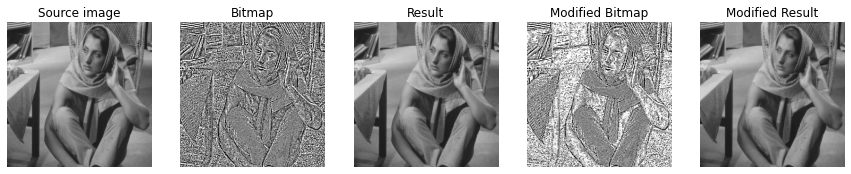

In [27]:
fig = plt.figure(figsize=(15, 15))
rows = 1
columns = 5

fig.add_subplot(rows, columns, 1)
plt.imshow(image,cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.title("Source image")

fig.add_subplot(rows, columns, 2)
plt.imshow(bitmap,cmap = 'gray', vmin = 0, vmax = 1)
plt.axis('off')
plt.title("Bitmap")

fig.add_subplot(rows, columns, 3)
plt.imshow(result,cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.title("Result")

fig.add_subplot(rows, columns, 4)
plt.imshow(bitmap_mod,cmap = 'gray', vmin = 0, vmax = 1)
plt.axis('off')
plt.title("Modified Bitmap")

fig.add_subplot(rows, columns, 5)
plt.imshow(result_mod,cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.title("Modified Result")